In [2]:
import numpy as np
import os
from time import time
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical

In [ ]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Lambda,Input,Dense, Flatten, Conv3D, MaxPooling3D, Dropout, Activation, LeakyReLU, Add, Multiply
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger,EarlyStopping,ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

In [ ]:
class DataGenerator(Sequence):
    """Data Generator inherited from keras.utils.Sequence
    Args: 
        directory: the path of data set, and each sub-folder will be assigned to one class
        batch_size: the number of data points in each batch
        shuffle: whether to shuffle the data per epoch
    """
    def __init__(self, directory, batch_size=1, shuffle=True, data_augmentation=True):
        self.batch_size = batch_size
        self.directory = directory
        self.shuffle = shuffle
        self.data_aug = data_augmentation

        self.X_path, self.Y_dict = self.search_data() 
        # Print basic statistics information
        self.print_stats()
        return None
        
    def search_data(self):
        X_path = []
        Y_dict = {}
        self.dirs = sorted(os.listdir(self.directory))
        one_hots = to_categorical(range(len(self.dirs)))
        for i,folder in enumerate(self.dirs):
            folder_path = os.path.join(self.directory,folder)
            for file in os.listdir(folder_path):
                file_path = os.path.join(folder_path,file)
    
                X_path.append(file_path)
                Y_dict[file_path] = one_hots[i]
        return X_path, Y_dict
    
    def print_stats(self):
        self.n_files = len(self.X_path)
        self.n_classes = len(self.dirs)
        self.indexes = np.arange(len(self.X_path))
        np.random.shuffle(self.indexes)
        print("Found {} files belonging to {} classes.".format(self.n_files,self.n_classes))
        for i,label in enumerate(self.dirs):
            print('%10s : '%(label),i)
        return None
    
    def __len__(self):
        # calculate the iterations of each epoch
        steps_per_epoch = np.ceil(len(self.X_path) / float(self.batch_size))
        return int(steps_per_epoch)

    def __getitem__(self, index):
        """Get the data of each batch
        """
        batch_indexs = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        batch_path = [self.X_path[k] for k in batch_indexs]
        batch_x, batch_y = self.data_generation(batch_path)
        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle == True:
            np.random.shuffle(self.indexes)

    def data_generation(self, batch_path):
        batch_x = [self.load_data(x) for x in batch_path]
        batch_y = [self.Y_dict[x] for x in batch_path]

        batch_x = np.array(batch_x)
        batch_y = np.array(batch_y)
        return batch_x, batch_y
      
    def normalize(self, data):
        mean = np.mean(data)
        std = np.std(data)
        return (data-mean) / std
    
    def random_flip(self, video, prob):
        s = np.random.rand()
        if s < prob:
            video = np.flip(m=video, axis=2)
        return video    
    
    def uniform_sampling(self, video, target_frames=64):
        len_frames = int(len(video))
        interval = int(np.ceil(len_frames/target_frames))
        sampled_video = []
        for i in range(0,len_frames,interval):
            sampled_video.append(video[i])     
        num_pad = target_frames - len(sampled_video)
        padding = []
        if num_pad>0:
            for i in range(-num_pad,0):
                try: 
                    padding.append(video[i])
                except:
                    padding.append(video[0])
            sampled_video += padding     
        # get sampled video
        return np.array(sampled_video, dtype=np.float32)
    
    def random_clip(self, video, target_frames=64):
        start_point = np.random.randint(len(video)-target_frames)
        return video[start_point:start_point+target_frames]
    
    
    def color_jitter(self,video):
        # range of s-component: 0-1
        # range of v component: 0-255
        s_jitter = np.random.uniform(-0.2,0.2)
        v_jitter = np.random.uniform(-30,30)
        for i in range(len(video)):
            hsv = cv2.cvtColor(video[i], cv2.COLOR_RGB2HSV)
            s = hsv[...,1] + s_jitter
            v = hsv[...,2] + v_jitter
            s[s<0] = 0
            s[s>1] = 1
            v[v<0] = 0
            v[v>255] = 255
            hsv[...,1] = s
            hsv[...,2] = v
            video[i] = cv2.cvtColor(hsv, cv2.COLOR_HSV2RGB)
        return video
        
    def load_data(self, path):
        data = np.load(path, mmap_mode='r')
        data = np.float32(data)
        data = self.uniform_sampling(video=data, target_frames=64)
        if  self.data_aug:
            data[...,:3] = self.color_jitter(data[...,:3])
            data = self.random_flip(data, prob=0.5)
        data[...,:3] = self.normalize(data[...,:3])
        data[...,3:] = self.normalize(data[...,3:])
        return data
    

In [ ]:
def get_rgb(input_x):
    rgb = input_x[...,:3]
    return rgb

def get_opt(input_x):
    opt= input_x[...,3:5]
    return opt

In [14]:
train_generator = DataGenerator(directory='/kaggle/input/data-rwf/preprocessed_data/train', 
                                batch_size=batch_size, 
                                data_augmentation=True)

val_generator = DataGenerator(directory='/kaggle/input/data-rwf/preprocessed_data/val',
                              batch_size=batch_size, 
                              data_augmentation=False)

Found 1600 files belonging to 2 classes.
     Fight :  0
  NonFight :  1
Found 400 files belonging to 2 classes.
     Fight :  0
  NonFight :  1


Đang load model từ file best_model_v2.h5...


Load model thành công!

--- Đang đánh giá (Evaluate) ---


I0000 00:00:1764163583.169887     108 service.cc:148] XLA service 0x7b88a5005310 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1764163583.170816     108 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1764163583.430847     108 cuda_dnn.cc:529] Loaded cuDNN version 90300
E0000 00:00:1764163584.764737     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764163585.019841     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764163585.665129     108 gpu_timer.cc:82] Delay kernel timed out: measured time has sub-optimal accuracy. There may be a missing warmup execution, please investigate in Nsight Systems.
E0000 00:00:1764163585.9302

50/50 ━━━━━━━━━━━━━━━━━━━━ 432s 9s/step - accuracy: 0.8980 - loss: 1.0124
Final Validation Loss: 1.0237
Final Validation Accuracy: 0.8575

--- Đang dự đoán (Predict) ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 174s 3s/step
Hoàn tất lấy dữ liệu!

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Fight       0.82      0.92      0.87       200
    NonFight       0.91      0.80      0.85       200

    accuracy                           0.86       400
   macro avg       0.86      0.86      0.86       400
weighted avg       0.86      0.86      0.86       400



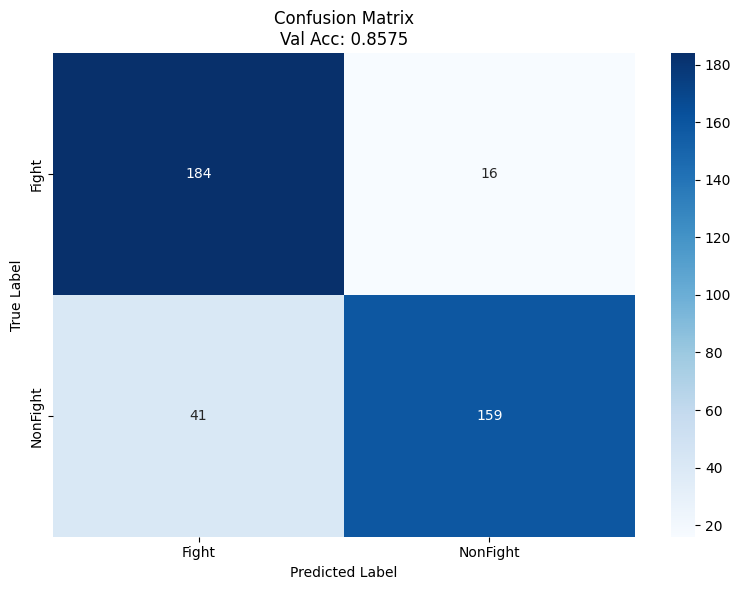

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model 

print("Đang load model từ file best_model_v2.h5...")
my_custom_objects = {
    'get_rgb': get_rgb,
    'get_opt': get_opt, 
    'tf': tf 
}
model = load_model('/kaggle/input/checkpoint2/best_model_v2.h5',custom_objects=my_custom_objects) 
print("Load model thành công!")

val_generator.shuffle = False 

val_generator.indexes = np.arange(len(val_generator.X_path))

print("\n--- Đang đánh giá (Evaluate) ---")
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

print("\n--- Đang dự đoán (Predict) ---")
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = []
for i in range(len(val_generator.X_path)):
    file_path = val_generator.X_path[i]   
    one_hot_label = val_generator.Y_dict[file_path] 
    y_true.append(np.argmax(one_hot_label)) 

y_true = np.array(y_true)

# Cắt ngắn nếu predict bị lệch (phòng hờ)
y_true = y_true[:len(y_pred)]

print("Hoàn tất lấy dữ liệu!")

target_names = val_generator.dirs 

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)

plt.title(f'Confusion Matrix\nVal Acc: {val_acc:.4f}') 
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300)
plt.show()

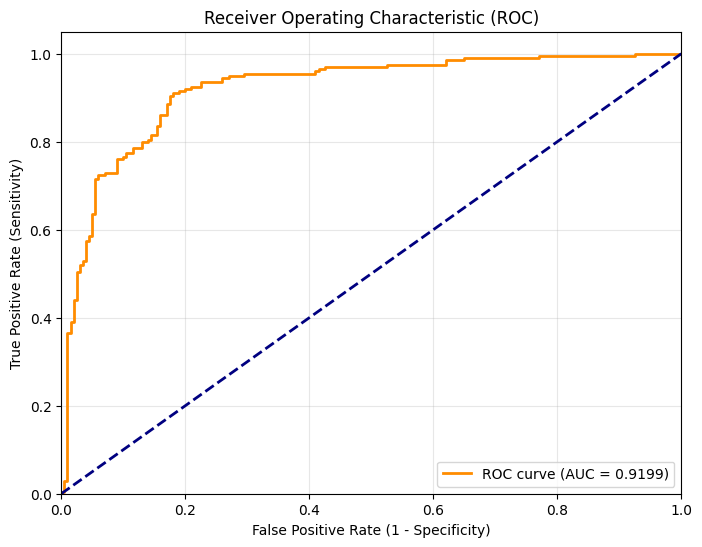

Kết luận: Diện tích dưới đường cong (AUC) là: 0.9199


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_fight = y_pred_prob[:, 0]

fpr, tpr, thresholds = roc_curve(y_true, y_prob_fight, pos_label=0)
roc_auc = auc(fpr, tpr)

# --- BƯỚC 3: Vẽ biểu đồ ---
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

# Lưu và hiển thị
plt.savefig('/kaggle/working/roc_auc_curve.png', dpi=300)
plt.show()

print(f"Kết luận: Diện tích dưới đường cong (AUC) là: {roc_auc:.4f}")

Đang load model từ file best_model.h5...


Load model thành công!

--- Đang đánh giá (Evaluate) ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 175s 3s/step - accuracy: 0.8662 - loss: 0.4321
Final Validation Loss: 0.3750
Final Validation Accuracy: 0.8650

--- Đang dự đoán (Predict) ---
50/50 ━━━━━━━━━━━━━━━━━━━━ 173s 3s/step
Hoàn tất lấy dữ liệu!

CLASSIFICATION REPORT
              precision    recall  f1-score   support

       Fight       0.87      0.86      0.86       200
    NonFight       0.86      0.87      0.87       200

    accuracy                           0.86       400
   macro avg       0.87      0.86      0.86       400
weighted avg       0.87      0.86      0.86       400



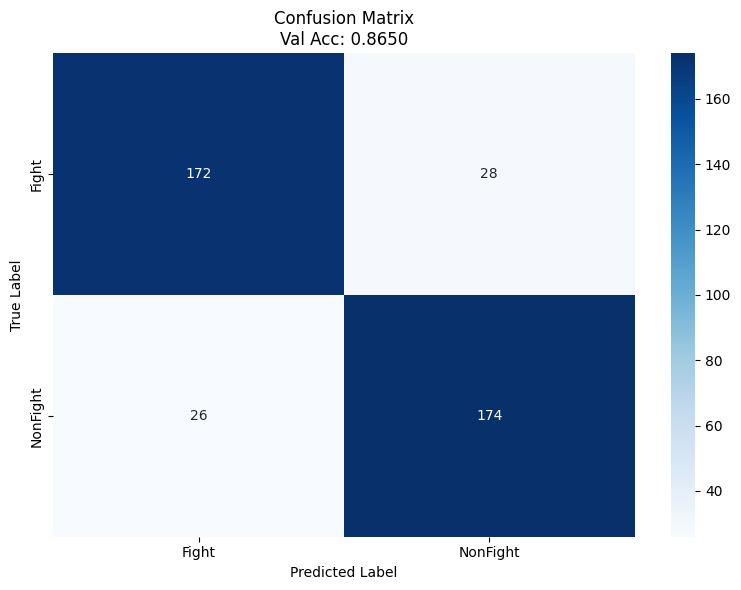

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model 


print("Đang load model từ file best_model.h5...")

my_custom_objects = {
    'get_rgb': get_rgb,
    'get_opt': get_opt,
    'tf': tf 
}
model = load_model('/kaggle/input/checkpoint/best_model_v1.h5',custom_objects=my_custom_objects) 
print("Load model thành công!")

val_generator.shuffle = False 

val_generator.indexes = np.arange(len(val_generator.X_path))

print("\n--- Đang đánh giá (Evaluate) ---")
val_loss, val_acc = model.evaluate(val_generator, verbose=1)
print(f"Final Validation Loss: {val_loss:.4f}")
print(f"Final Validation Accuracy: {val_acc:.4f}")

print("\n--- Đang dự đoán (Predict) ---")
y_pred_prob = model.predict(val_generator, verbose=1)
y_pred = np.argmax(y_pred_prob, axis=1)

y_true = []
for i in range(len(val_generator.X_path)):
    file_path = val_generator.X_path[i]   
    one_hot_label = val_generator.Y_dict[file_path]
    y_true.append(np.argmax(one_hot_label)) 

y_true = np.array(y_true)

# Cắt ngắn nếu predict bị lệch (phòng hờ)
y_true = y_true[:len(y_pred)]

print("Hoàn tất lấy dữ liệu!")

target_names = val_generator.dirs 

print("\n" + "="*50)
print("CLASSIFICATION REPORT")
print("="*50)
print(classification_report(y_true, y_pred, target_names=target_names))

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=target_names,
            yticklabels=target_names)

plt.title(f'Confusion Matrix\nVal Acc: {val_acc:.4f}') 
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.savefig('/kaggle/working/confusion_matrix.png', dpi=300)
plt.show()

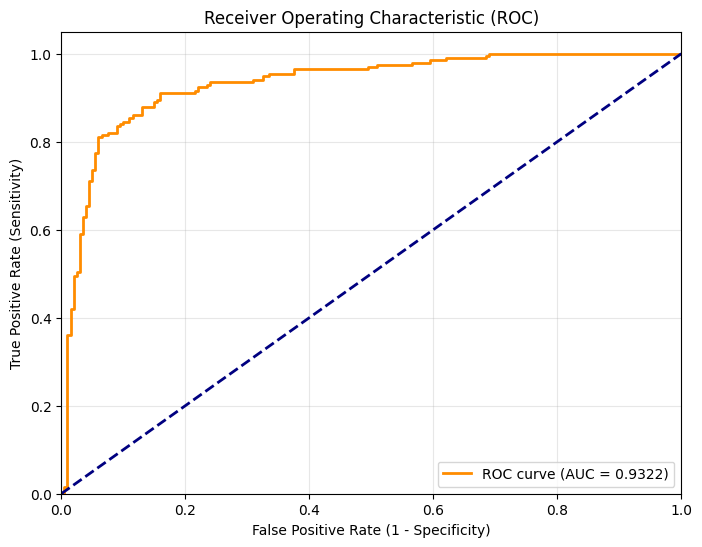

Kết luận: Diện tích dưới đường cong (AUC) là: 0.9322


In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_prob_fight = y_pred_prob[:, 0]

fpr, tpr, thresholds = roc_curve(y_true, y_prob_fight, pos_label=0)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--') 

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.grid(True, alpha=0.3)

plt.savefig('/kaggle/working/roc_auc_curve.png', dpi=300)
plt.show()

print(f"Kết luận: Diện tích dưới đường cong (AUC) là: {roc_auc:.4f}")